Домашняя работа
Подробнее описание и данные находятся в файле Practice_1_2.ipynb (вложение Материалы к занятию). Это задание мы разберем на следующем занятии в кампусе. 

Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
 
Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

общая сумма транзакций по каждой из trx_category
общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
 
Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
 
Дополнительная часть: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Метрика оценки качества - ROC AUC(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
 
Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np
from sklearn.metrics import roc_auc_score
import xgboost 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve

raw_df = pd.read_csv('rosbank_train.csv')
raw_df = raw_df.drop(columns='target_sum', axis=1)

In [2]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df

In [3]:
#MCC_list = raw_df.MCC.value_counts().head(20).index.tolist()

In [4]:
def trnx_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset.groupby(['cl_id'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [5]:
def transaction_by_hour1_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'hour_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df

In [6]:
import sqlite3
conn = sqlite3.connect('transactions.db')
raw_df.to_sql('transactions_raw', if_exists='replace', con=conn)
df09 = pd.io.sql.read_sql("""
    select
        cl_id,
        target_flag,
        sum(case when MCC = 5411 then amount else 0 end) as MCC5411,
        sum(case when MCC = 6011 then amount else 0 end) as MCC6011,
        sum(case when MCC = 5814 then amount else 0 end) as MCC5814,
        sum(case when MCC = 5812 then amount else 0 end) as MCC5812,
        sum(case when MCC = 5499 then amount else 0 end) as MCC5499,
        sum(case when MCC = 5912 then amount else 0 end) as MCC5912,
        sum(case when MCC = 5999 then amount else 0 end) as MCC5999,
        
/*----------------------avgerage amount----------------------------*/       
        avg(case when MCC = 5411 then amount else 0 end) as MCC5411_avg,
        avg(case when MCC = 6011 then amount else 0 end) as MCC6011_avg,
        avg(case when MCC = 5814 then amount else 0 end) as MCC5814_avg,
        avg(case when MCC = 5812 then amount else 0 end) as MCC5812_avg,
        avg(case when MCC = 5499 then amount else 0 end) as MCC5499_avg,
        avg(case when MCC = 5912 then amount else 0 end) as MCC5912_avg,
        avg(case when MCC = 5999 then amount else 0 end) as MCC5999_avg
        
    from transactions_raw
    group by 1, 2
    order by 1
    """, conn)

In [7]:
df10 = raw_df.groupby(['cl_id']).agg({'amount':['sum','min','max']})
df10 = df10.reset_index(col_level=1)
df10.columns = df10.columns.get_level_values(1)
df11 = transaction_by_day_count(raw_df)
df12 = transaction_by_hour1_count(raw_df)
df13 = df10.set_index('cl_id').join(df11)
df14 = df13.join(df12.set_index('cl_id'))
df15 = df14.join(df09.set_index('cl_id'))
df16 = raw_df [ (raw_df['trx_category'].isin(['DEPOSIT','BACK_TRX','C2C_IN'])) ].groupby(['cl_id'])['amount'].sum()
df17 = raw_df [ ~ (raw_df['trx_category'].isin(['DEPOSIT','BACK_TRX','C2C_IN'])) ].groupby(['cl_id'])['amount'].sum()
df16 = df16.rename('total_income')
df17 = df17.rename('total_outcome')
df18 = df15.join(df16).join(df17)
#df19 = df18['total_income'].map(lambda x: x pd.isnull(x)?0:x) - df18['total_outcome'] < df18['total_outcome'] / 2
df18.replace({np.nan:0}, inplace=True)
#df18['no_pay'] = df18['total_income']==0

In [8]:
# Divide by 1.5 to limit the number of income categories
df18["sum_cat"] = np.ceil(df18["sum"] / 150000)
# Label those above 5 as 5
df18["sum_cat"].where(df18["sum_cat"] != 0.0, 1.0, inplace=True)
df18["sum_cat"].where(df18["sum_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df18, df18["sum_cat"]):
    strat_train_set = df18.iloc[train_index]
    strat_test_set = df18.iloc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("sum_cat", axis=1, inplace=True)
    
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer

num_attribs = strat_train_set.columns.drop(["target_flag"])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
])

In [10]:
X_train = strat_train_set.drop("target_flag", axis=1)
y_train = strat_train_set["target_flag"].copy()

X_test = strat_test_set.drop("target_flag", axis=1)
y_test = strat_test_set["target_flag"].copy()

In [11]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train_prepared, y_train)
y_pred = lin_reg.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

0.45937166383652484

In [13]:
columns = list(X_train)
columns.append('target_flag')

train_df = pd.DataFrame(np.c_[X_train_prepared, y_train], columns=columns)
test_df = pd.DataFrame(np.c_[X_test_prepared, y_test], columns=columns)
 

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

_iteration_cols = train_df.columns.drop('target_flag')

def get_formula(_cols):
    return 'target_flag ~ ' + " + ".join(_cols)

In [15]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.4514294017703619
R^2: 0.17513546939864066


In [16]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5543,0.007,77.154,0.000,0.540,0.568
sum,0.0108,0.022,0.498,0.618,-0.032,0.053
min,0.0051,0.007,0.703,0.482,-0.009,0.019
max,-0.0045,0.026,-0.174,0.862,-0.055,0.046
cl_id,0.0729,0.008,8.940,0.000,0.057,0.089
day_0,-0.0049,0.017,-0.293,0.770,-0.037,0.028
day_1,0.0361,0.020,1.790,0.074,-0.003,0.076
day_2,0.0006,0.020,0.029,0.977,-0.039,0.040
day_3,0.0054,0.020,0.268,0.789,-0.034,0.045
day_4,0.0217,0.021,1.029,0.304,-0.020,0.063


In [17]:
_iteration_cols = _iteration_cols.drop('day_2')
_iteration_cols = _iteration_cols.drop('hour_08')
_iteration_cols = _iteration_cols.drop('hour_07')
_iteration_cols = _iteration_cols.drop('hour_19')
_iteration_cols = _iteration_cols.drop('hour_11')

_iteration_cols = _iteration_cols.drop('MCC5499_avg')
_iteration_cols = _iteration_cols.drop('MCC5812_avg')
_iteration_cols = _iteration_cols.drop('MCC5814_avg')

In [18]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.45146527061233593
R^2: 0.17500438307234434


In [19]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5543,0.007,77.226,0.000,0.540,0.568
sum,0.0080,0.021,0.388,0.698,-0.032,0.048
min,0.0050,0.007,0.690,0.490,-0.009,0.019
max,-0.0002,0.024,-0.007,0.995,-0.047,0.047
cl_id,0.0731,0.008,9.019,0.000,0.057,0.089
day_0,-0.0050,0.017,-0.304,0.761,-0.037,0.027
day_1,0.0364,0.019,1.868,0.062,-0.002,0.075
day_3,0.0055,0.020,0.284,0.776,-0.033,0.044
day_4,0.0219,0.020,1.071,0.284,-0.018,0.062
day_5,0.0162,0.020,0.823,0.411,-0.022,0.055


In [20]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.45146527061233593
R^2: 0.17500438307234434


In [21]:
xgb = xgboost.XGBClassifier(max_depth=3, n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
y_test_predict = xgb.predict_proba(X_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.88
Test:  0.79


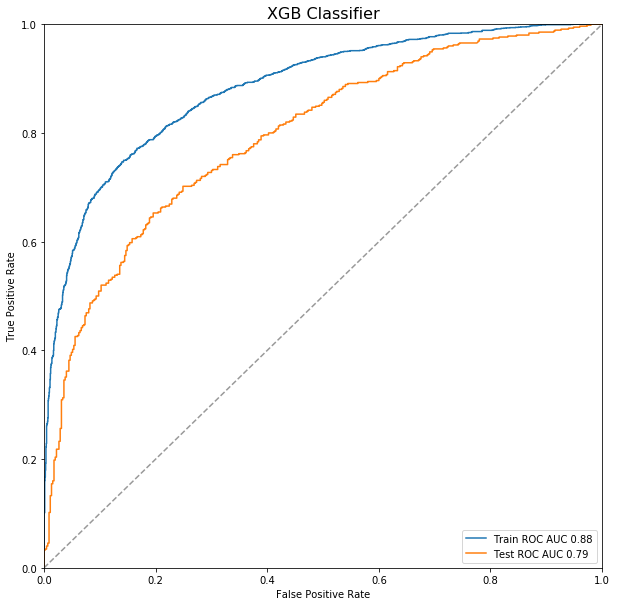

In [22]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

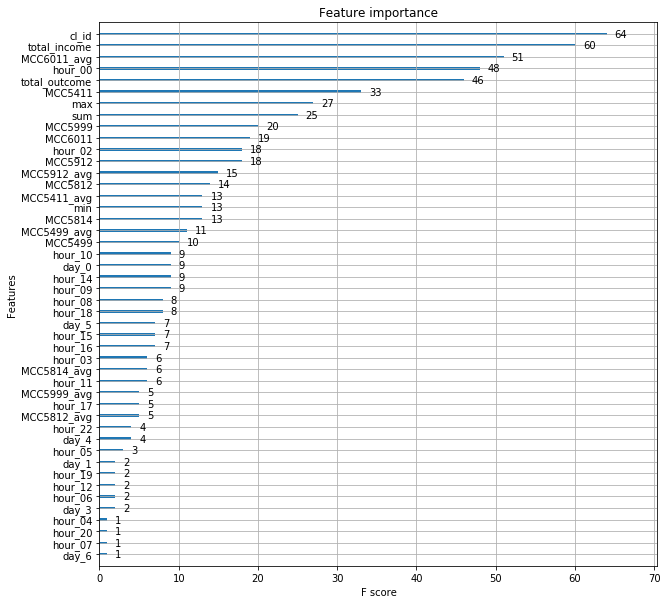

In [23]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')